In [1]:
#Link to dataset
#https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification




Importing libraries

In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
import spacy
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
import shap
from sklearn.pipeline import Pipeline

In [3]:
df = pd.read_csv(r"C:\Users\ILLO STEPHANIE NZUBE\Documents\WELFake_Dataset.csv")

"""For the label, 0 means fake and 1 means real."""

'For the label, 0 means fake and 1 means real.'

In [4]:
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [5]:
df = df.drop('Unnamed: 0', axis = 1)

In [6]:
df.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   71576 non-null  object
 1   text    72095 non-null  object
 2   label   72134 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [8]:
df.shape

(72134, 3)

In [9]:
df.isnull().sum()

title    558
text      39
label      0
dtype: int64

In [10]:
rows_with_null = df[df.isnull().any(axis = 1)]
rows_with_null

,title,text,label
1,NaN,Did they post their votes for Hillary already?,1
43,NaN,True. Hillary needs a distraction and what bet...,1
162,NaN,All eyes on Electoral delegates. The People kn...,1
185,NaN,Cool,1
269,NaN,A leading US senator: US Supporting War in Syr...,1
...,...,...,...
71484,NaN,Another Arab supremacist masturbation fantasy....,1
71521,NaN,I'm sure they drastically changed accounting m...,1
71540,NaN,It's easy to imagine Obama or Kerry pissing hi...,1
71570,NaN,Ever since the powers to be assassinated JFK A...,1


In [11]:
df = df.dropna()
df.isnull().sum()

title    0
text     0
label    0
dtype: int64

Checking for duplicates

In [12]:
num_of_duplicates = df.duplicated().sum()
print("The number of duplicates is: ", num_of_duplicates)

The number of duplicates is:  8416


Viewing the duplicates

In [13]:
df[df.duplicated(keep=False)].sort_values(by=df.columns.tolist()).head(20)

,title,text,label
34585,"""Top Five Clinton Donors Are Jewish"" - How Ant...","""Top Five Clinton Donors Are Jewish"" - How Ant...",1
40330,"""Top Five Clinton Donors Are Jewish"" - How Ant...","""Top Five Clinton Donors Are Jewish"" - How Ant...",1
15085,#2816: Clinton Pride’s 8(a) Pig Farm Bridge – ...,United States Marine Field McConnell Plum Cit...,1
22321,#2816: Clinton Pride’s 8(a) Pig Farm Bridge – ...,United States Marine Field McConnell Plum Cit...,1
1946,#AnyoneButHillary: NEW POLL Shows Bernie Suppo...,Hillary may find out she needs more than black...,1
22104,#AnyoneButHillary: NEW POLL Shows Bernie Suppo...,Hillary may find out she needs more than black...,1
44258,#Austin: Fights Break Out Between Police and S...,Commies carrying flags fought with the Austin ...,1
44689,#Austin: Fights Break Out Between Police and S...,Commies carrying flags fought with the Austin ...,1
1109,#BREAKING: SECOND Assassination Attempt On Tru...,We Are Change \nDonald Trump on Saturday was q...,1
63047,#BREAKING: SECOND Assassination Attempt On Tru...,We Are Change \nDonald Trump on Saturday was q...,1


Dropping the duplicates

In [14]:
print(df.shape)
df = df.drop_duplicates()
print(df.shape)

(71537, 3)
(63121, 3)


Checking the distribution of Real vs Fake news

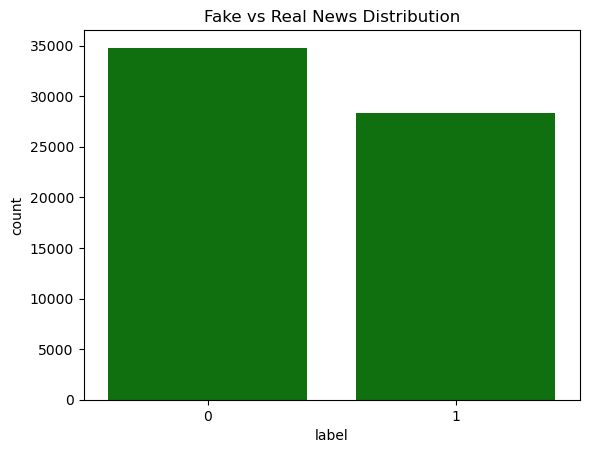

'The dataset is relatively balanced with fake news slightly more common (55%) than real news (45%). This balance reduces the risk of bias toward the majority class.'

In [15]:
sns.countplot(x="label", data = df, color = "green")
plt.title("Fake vs Real News Distribution")
plt.show()

df["label"].value_counts(normalize=True)

"""The dataset is relatively balanced with fake news slightly more common (55%) than real news (45%). This balance reduces the risk of bias toward the majority class."""

Text Length Analysis

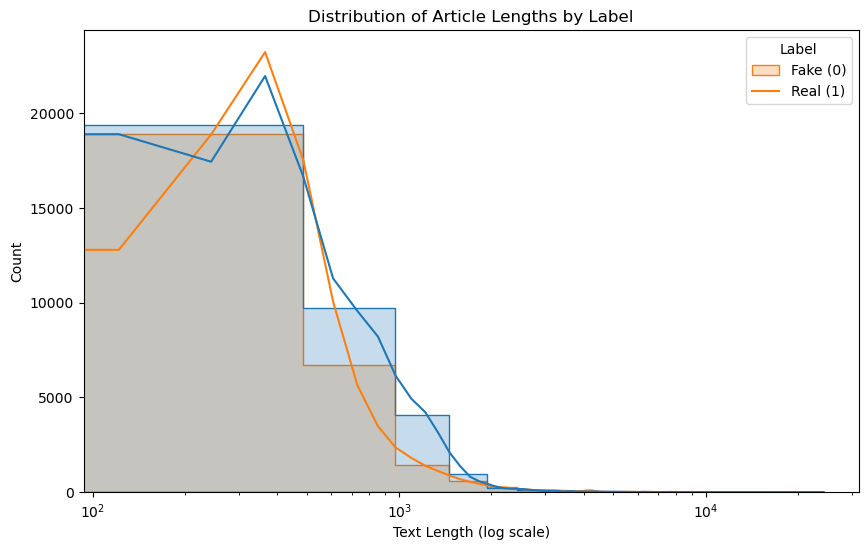

In [16]:
df["text_length"] = df["text"].str.split().str.len().astype(int)

#Histogram with log scale for better visibility
plt.figure(figsize=(10,6))
sns.histplot(
    data = df,
    x = "text_length",
    hue = "label",
    bins = 50,
    kde = True,
    element = "step"    #draws smooth line histogram
)

plt.xscale("log")
plt.xlabel("Text Length (log scale)")
plt.title("Distribution of Article Lengths by Label")
plt.legend(title = "Label", labels = ["Fake (0)", "Real (1)"])
plt.show()

In [17]:
df.groupby("label")["text_length"].agg(["count", "mean", "median", "std"])

#"""Article length may be a useful but not definitive feature for classification"""

,count,mean,median,std
label,,,,
0,34791,578.252278,427.0,564.396511
1,28330,507.855101,379.0,662.262837


Generating word clouds for real and fake news

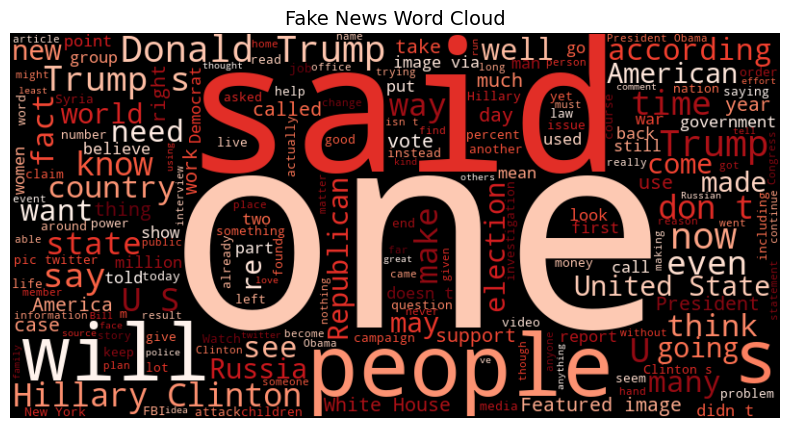

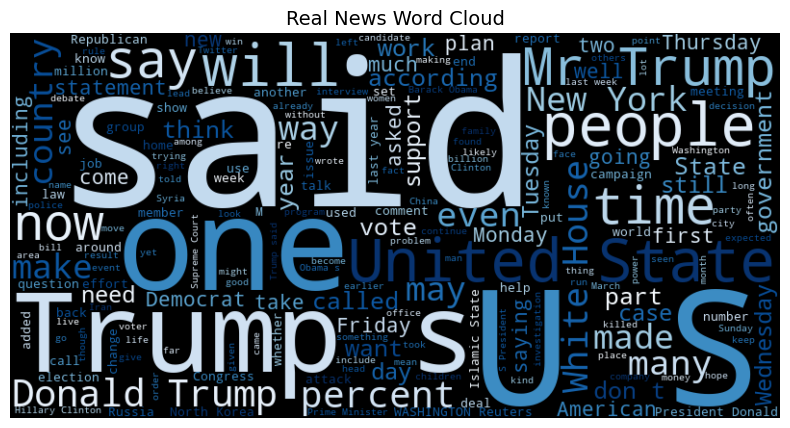

In [18]:
#Prepare text
fake_text = "".join(df[df['label']==1]['text'].dropna().astype(str))
real_text = "".join(df[df['label']==0]['text'].dropna().astype(str))

#Common Stopwords
stop_words = set(STOPWORDS)

#Fake news word clouds
wc_fake = WordCloud(width=800,
                    height = 400,
                    background_color = 'black',
                    stopwords=stop_words,
                    colormap='Reds').generate(fake_text)
plt.figure(figsize=(10,5))
plt.imshow(wc_fake, interpolation='bilinear')
plt.axis('off')
plt.title('Fake News Word Cloud', fontsize = 14)
plt.show()

#Real news word clouds
wc_real = WordCloud(width=800,
                    height = 400,
                    background_color = 'black',
                    stopwords=stop_words,
                    colormap='Blues').generate(real_text)
plt.figure(figsize=(10,5))
plt.imshow(wc_real, interpolation='bilinear')
plt.axis('off')
plt.title('Real News Word Cloud', fontsize = 14)
plt.show()

In [19]:
def get_top_n_words(texts, n=20):
    #Simple tokenizer: lowercase + keep only words
    tokens = [word for text in texts for word in re.findall(r'\b[a-z]+\b', str(text).lower())]
    return Counter(tokens).most_common(n)

#Top 20 words in Fake news
fake_top = get_top_n_words(df[df['label']==1]['text'].dropna(), 20)
print("Top words in Fake News:\n", fake_top)

#Top 20 words in Real news
real_top = get_top_n_words(df[df['label']==0]['text'].dropna(), 20)
print("\nTop words in Real News:\n", fake_top)

Top words in Fake News:
 [('the', 795210), ('to', 407409), ('of', 360371), ('and', 342338), ('a', 297785), ('in', 251778), ('that', 212670), ('s', 176122), ('is', 171489), ('for', 130945), ('it', 121865), ('on', 112737), ('he', 92196), ('with', 90565), ('trump', 89480), ('as', 87663), ('was', 84878), ('this', 84674), ('are', 76185), ('be', 74392)]

Top words in Real News:
 [('the', 795210), ('to', 407409), ('of', 360371), ('and', 342338), ('a', 297785), ('in', 251778), ('that', 212670), ('s', 176122), ('is', 171489), ('for', 130945), ('it', 121865), ('on', 112737), ('he', 92196), ('with', 90565), ('trump', 89480), ('as', 87663), ('was', 84878), ('this', 84674), ('are', 76185), ('be', 74392)]


In [20]:
"""There isn't a significant difference in the most frequent words in the fake news class and the real news class"""

"There isn't a significant difference in the most frequent words in the fake news class and the real news class"

TEXT CLEANING AND LEMMATIZATION

In [21]:
#nltk.download("stopwords")
#nltk.download("wordnet")
#nltk.download("omw-1.4")

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    #Lowercase
    text = text.lower()

    #Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)

    #Remove punctuations
    text = text.translate(str.maketrans("", "", string.punctuation))

    #Remove numbers
    text = re.sub(r"\d+", "", text)

    #Tokenize 
    tokens = text.split()
    
    #Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [22]:
#Apply cleaning

df["clean_text"] = df["text"].apply(clean_text)
df[["text", "clean_text"]].head(20)

,text,clean_text
0,No comment is expected from Barack Obama Membe...,comment expected barack obama member fyf fukyo...
2,"Now, most of the demonstrators gathered last ...",demonstrator gathered last night exercising co...
3,A dozen politically active pastors came here f...,dozen politically active pastor came private d...
4,"The RS-28 Sarmat missile, dubbed Satan 2, will...",r sarmat missile dubbed satan replace s fly mi...
5,All we can say on this one is it s about time ...,say one time someone sued southern poverty law...
6,DR. BEN CARSON TELLS THE STORY OF WHAT HAPPENE...,dr ben carson tell story happened spoke obama
7,,
8,"The owner of the Ringling Bar, located south o...",owner ringling bar located south white sulphur...
9,"FILE – In this Sept. 15, 2005 file photo, the ...",file – sept file photo marker welcome commuter...
10,The most punchable Alt-Right Nazi on the inter...,punchable altright nazi internet got thorough ...


In [23]:
#Splitting data into Train/Test

X = df["text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

In [24]:
#TF-IDF Vectorization {Baseline representation for ML models

tfidf = TfidfVectorizer(stop_words = "english", max_features=5000)  

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("Train shape:", X_train_tfidf.shape)
print("Test shape:", X_test_tfidf.shape)

Train shape: (50496, 5000)
Test shape: (12625, 5000)


In [25]:
#Saving Vectorizer
#joblib.dump(tfidf, "tfidf_vectorizer.pkl")

In [26]:
#Baseline Model (Logistic Regression)

lr_model = LogisticRegression(max_iter = 1000)
lr_model.fit(X_train_tfidf, y_train)

#Predictions
y_pred = lr_model.predict(X_test_tfidf)

#Evaluation
print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('Confusion Matrix:', confusion_matrix(y_test, y_pred))

Logistic Regression Results:
Accuracy: 0.9361584158415842
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      6959
           1       0.93      0.93      0.93      5666

    accuracy                           0.94     12625
   macro avg       0.94      0.94      0.94     12625
weighted avg       0.94      0.94      0.94     12625

Confusion Matrix: [[6553  406]
 [ 400 5266]]


In [27]:
#Another baseline model (Naive Bayes)

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

#Prediction
y_pred_nb = nb_model.predict(X_test_tfidf)

#Evaluation
print("Naive Bayes Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))
print('Confusion Matrix:', confusion_matrix(y_test, y_pred_nb))

Naive Bayes Results:
Accuracy: 0.8346138613861386
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      6959
           1       0.81      0.82      0.82      5666

    accuracy                           0.83     12625
   macro avg       0.83      0.83      0.83     12625
weighted avg       0.83      0.83      0.83     12625

Confusion Matrix: [[5871 1088]
 [1000 4666]]


In [28]:
#Applying cross-validation with Naive Bayes and Logistic Regression

#Naive Bayes CV
nb_model = MultinomialNB()
nb_cv_scores = cross_val_score(nb_model, X_train_tfidf, y_train, cv=5, scoring = "f1")
print("Naive Bayes CV F1 scores:", nb_cv_scores)
print("Naive Bayes Mean F1:", np.mean(nb_cv_scores))

#Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_cv_scores = cross_val_score(lr_model, X_train_tfidf, y_train, cv=5, scoring="f1")
print("Logistic Regression CV F1 scores:", lr_cv_scores)
print("Logistic Regression Mean F1:", np.mean(lr_cv_scores))


Naive Bayes CV F1 scores: [0.82592958 0.81668857 0.82063509 0.81822183 0.81323   ]
Naive Bayes Mean F1: 0.8189410140294978
Logistic Regression CV F1 scores: [0.92917722 0.92566158 0.92677018 0.92609318 0.92270531]
Logistic Regression Mean F1: 0.9260814953480028


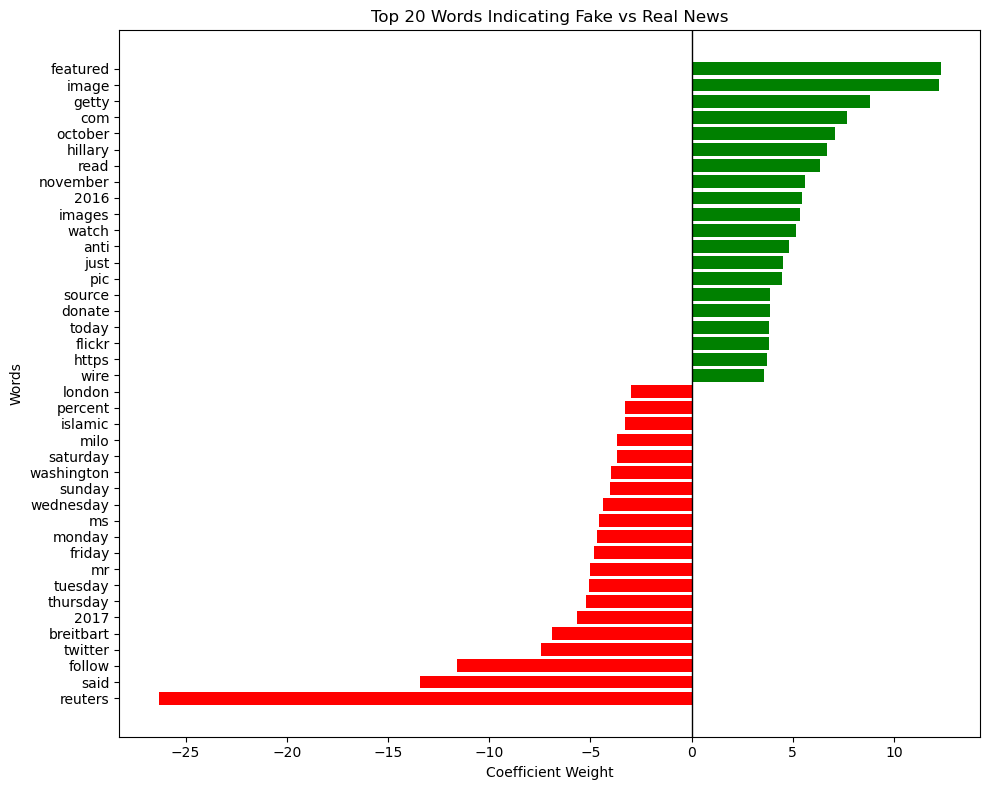

In [29]:
#Feature importance of Real vs Fake News

#Feature names from TF-IDF vectorizer
feature_names = tfidf.get_feature_names_out()

#Getting coefficients from logistic regression
lr_model = LogisticRegression(max_iter = 1000)
lr_model.fit(X_train_tfidf, y_train)
coefs = lr_model.coef_[0]

#Top 20 fake-indicative words (most negative coefficients)
top_fake_idx = np.argsort(coefs)[:20]
top_fake_words = [(feature_names[i], coefs[i]) for i in top_fake_idx]

#Top 20 real-indicative words (most positive coefficients)
top_real_idx = np.argsort(coefs)[-20:]
top_real_words = [(feature_names[i], coefs[i]) for i in top_real_idx]

#Separate words and weights
fake_words, fake_weights = zip(*top_fake_words)
real_words, real_weights = zip(*top_real_words)

# ---------------Mirrored bar plot-----------------
plt.figure(figsize = (10,8))

#Fake news (negative side, red)
plt.barh(fake_words, fake_weights, color = "red")

#Real news (positive side, green)
plt.barh(real_words, real_weights, color = "green")

plt.axvline(0, color = "black", linewidth = 1)  #vertical line at 0
plt.title("Top 20 Words Indicating Fake vs Real News")
plt.xlabel("Coefficient Weight")
plt.ylabel("Words")
plt.tight_layout()
plt.show()

LinearExplainer explainer: 12626it [00:22, 212.08it/s]


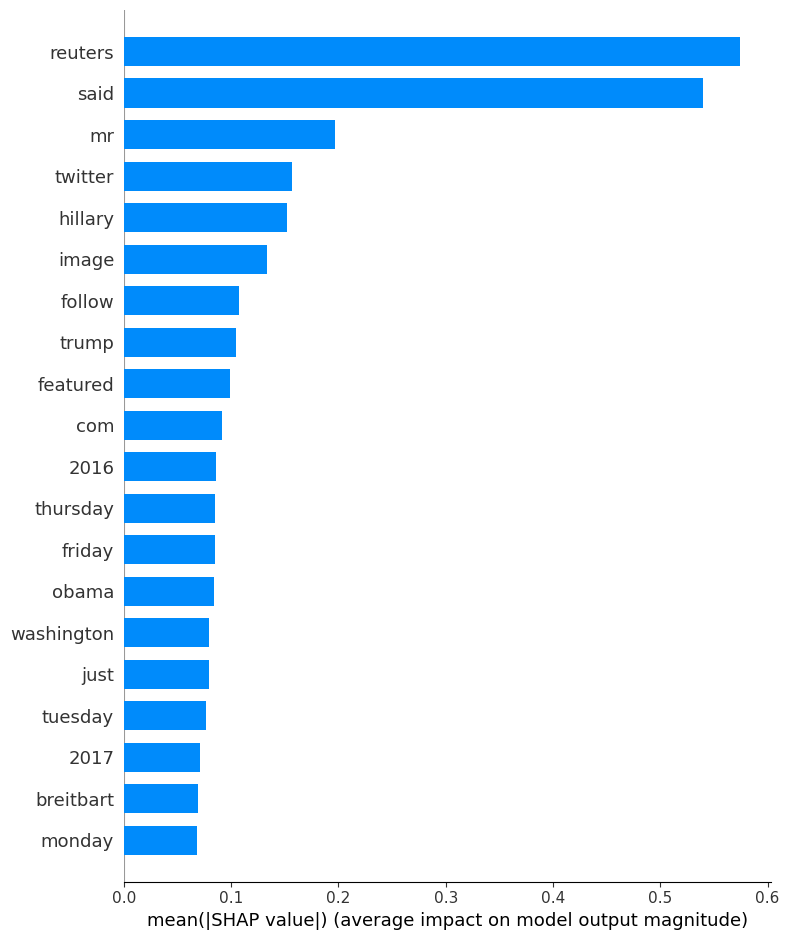

In [30]:
#SHAP Explanations (Word_level Influence)

#Creating independent masker for sparse tf_idf data
masker = shap.maskers.Independent(X_train_tfidf)

#Initializing SHAP LinearExplainer with trainer LR model
explainer = shap.LinearExplainer(lr_model, masker = masker)

#Computing SHAP Values for tfidf test data
shap_values = explainer(X_test_tfidf)

#Global Explanation: Summary bar plot of top features
shap.summary_plot(shap_values, X_test_tfidf, feature_names = tfidf.get_feature_names_out(), plot_type='bar')

#Local Explanation (example: first three news article in test set)
for i in range(3):
    shap.plots.force(shap_values[i])

Deployment of the model

In [32]:
#Pipeline = cleaning + TF-IDF + Logistic Regression
  
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words = "english")),
    ("clf", LogisticRegression(max_iter = 1000))
])

#Train
pipeline.fit(X_train, y_train)

#Evaluate
print("Accuracy:", pipeline.score(X_test, y_test))

Accuracy: 0.9389306930693069


In [27]:
#Saving the model
joblib.dump(pipeline, "fake_news_model.pkl")

#To reload when needed
#model = joblib.load("fake_news_model.pkl")

['fake_news_model.pkl']

In [28]:
#For deployment, we are using an API
from fastapi import FastAPI

app = FastAPI()
model = joblib.load("fake_news_model.pkl")

@app.post("/predict")
def predict(news:str):
    pred = model.predict([news])[0]
    prob = model.predict_proba([news])[0].max()
    label = "Real" if pred ==1 else "Fake"
    return {"label": label, "confidence":float(prob)}

In [29]:
code = """
from fastapi import FastAPI
import joblib
app = FastAPI()
model = joblib.load("fake_news_model.pkl")

@app.post("/predict")
def predict(news:str):
    pred = model.predict([news])[0]
    prob = model.predict_proba([news])[0].max()
    label = "Real" if pred ==1 else "Fake"
    return {"label": label, "confidence":float(prob)}
"""
with open("app.py", "w") as f:
    f.write(code)

print("Successful")

Successful


In [ ]:
uvicorn app:app --reload

In [ ]:
#!{sys.executable} -m pip install shap

In [ ]:
#!{sys.executable} -m spacy download en_core_web_sm
#You can now load the package via spacy.load('en_core_web_sm')